# Clasificación de Radiografías de Tórax para Detección de Condiciones Pulmonares

### Diccionario de Datos

El conjunto de datos se encuentra en la ruta: `/content/drive/MyDrive/Colab Notebooks/Proyectos_DS_2025/PDS_Operaciones/Dataset (1)`.

Este dataset contiene imágenes de radiografías de tórax clasificadas en las siguientes categorías:

*   **0**: COVID-19
*   **1**: Normal
*   **2**: Neumonía Virica
*   **3**: Neumonía Bacteriana

Trabajaremos con estas imágenes para entrenar un modelo de clasificación que pueda identificar estas diferentes condiciones pulmonares.

# 1: IMPORTAR LIBRERÍAS Y CONJUNTO DE DATOS

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
# Necesitarás montar tu disco usando los siguientes comandos:
# Para obtener más información sobre el montaje, consulta esto: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# Especificar el directorio del conjunto de entrenamiento
XRay_Directory="/content/drive/MyDrive/Colab Notebooks/Proyectos_DS_2025/PDS_Operaciones/Dataset (1)"

In [4]:
# Listar las carpetas de dicho directorio
os.listdir(XRay_Directory)

['1', '0', '2', '3']

In [5]:
# Utilizar el generador de imágenes para generar datos de imágenes de tensores y normalizarlos
# Utilizar el 20% de los datos para la validación cruzada posterior
image_generator=ImageDataGenerator(rescale=1./255, validation_split=0.2,)

In [6]:
# Genere lotes de 40 imágenes
# El número total de imágenes es 133 * 4 = 532 imágenes
# El entrenamiento usará es 428 (80%) y la validación usará 104 (20%)
# Realizar muestreo aleatoria y cambio del tamaño en las imágenes
train_generator=image_generator.flow_from_directory(
    XRay_Directory,
    target_size=(256, 256),
    batch_size=40,
    class_mode='categorical',
    subset='training',
    shuffle=True,)

Found 428 images belonging to 4 classes.


In [7]:
#configuramos imagenes de validacion
train_generator=image_generator.flow_from_directory(
    XRay_Directory,
    target_size=(256, 256),
    batch_size=40,
    class_mode='categorical',
    subset='validation',
    shuffle=True,)

Found 104 images belonging to 4 classes.


In [8]:
# Generar un lote de 40 imágenes y etiquetas
train_images,train_labels=next(train_generator)

In [9]:
train_images.shape

(40, 256, 256, 3)

In [10]:
train_labels.shape

(40, 4)

In [11]:
train_labels

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]],

In [12]:
# Traductor de cada Etiqueta
label_names={0:"COVID-19",1:"Normal",2:"Pneumonia Virica",3:"Pneumonia Bacteriana"}

# 2: VISUALIZACIÓN DEL DATASET

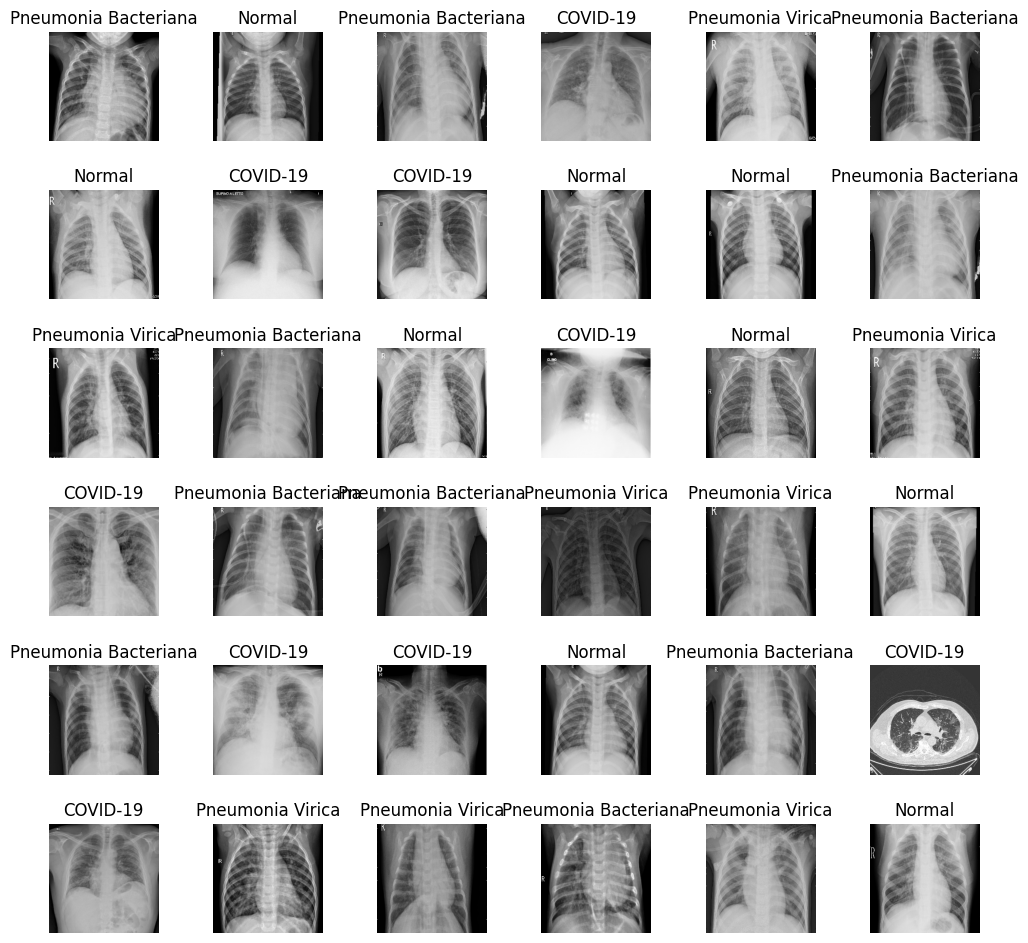

In [13]:
# Crea una matriz de 36 imágenes junto con sus etiquetas correspondientes
L=6
W=6
fig, axes=plt.subplots(L, W, figsize=(12, 12))
axes=axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)


# 3: IMPORTAR EL MODELO CON PESOS PRE ENTRENADOS

In [14]:
basemodel=ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [15]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [16]:
# Congelar el modelo hasta las últimas etapas - 4 y llevar a cabo un re entrenamiento -5
for layer in basemodel.layers[:-10]:
    layer.trainable=False

# 4: CONSTRUIR Y ENTRENAR UN MODELO DE DEEP LEARNING

In [17]:
headmodel=basemodel.output
headmodel=AveragePooling2D(pool_size=(4, 4))(headmodel)
headmodel=Flatten(name='flatten')(headmodel)
headmodel=Dense(256, activation='relu')(headmodel)
headmodel=Dropout(0.3)(headmodel)
headmodel=Dense(128, activation='relu')(headmodel)
headmodel=Dropout(0.2)(headmodel)
headmodel=Dense(4, activation='softmax')(headmodel)

model=Model(inputs=basemodel.input, outputs=headmodel)

Copilar el modelo con funcion de perdida

In [18]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4,weight_decay=1e-6), metrics=['accuracy'])

In [19]:
# Usar la parada temprana (early stopping) para salir del entrenamiento si la pérdida en la validación no disminuye incluso después de ciertas épocas (paciencia)
earlyStopping= EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=20)


# Almacenar el mejor modelo con la menor pérdida en la validación
chekpointer= ModelCheckpoint(filepath='weights.keras',verbose=1,save_best_only=True)

In [20]:
train_generator=image_generator.flow_from_directory(
    XRay_Directory,
    target_size=(256, 256),
    batch_size=4,
    class_mode='categorical',
    subset='training',
    shuffle=True,)
val_generator=image_generator.flow_from_directory(
    XRay_Directory,
    target_size=(256, 256),
    batch_size=4,
    class_mode='categorical',
    subset='validation',
    shuffle=True,)

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [21]:
history=model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // 4,
    epochs=25,
    callbacks=[earlyStopping, chekpointer],
    validation_data=val_generator,
    validation_steps=val_generator.n//4)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3149 - loss: 1.6190
Epoch 1: val_loss improved from inf to 1.41125, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.3151 - loss: 1.6175 - val_accuracy: 0.2500 - val_loss: 1.4112
Epoch 2/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5481 - loss: 1.0720
Epoch 2: val_loss improved from 1.41125 to 1.14716, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.5481 - loss: 1.0722 - val_accuracy: 0.5096 - val_loss: 1.1472
Epoch 3/25
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5737 - loss: 0.9695
Epoch 3: val_loss did not improve from 1.14716
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.5742 - loss: 0.9689 - val_accuracy: 0.4808 - val_loss: 1.2618
Epoch 4/25
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6843 - loss: 0.8410
Epoch 4: val_loss improved from 1.14716 to 0.89729, saving model to weights.keras
107/107 ━━

# 5: EVALUAR EL MODELO DE DEEP LEARNING ENTRENADO

In [22]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

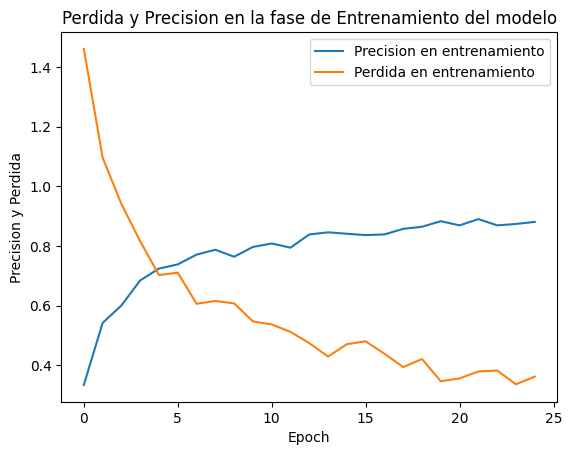

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title("Perdida y Precision en la fase de Entrenamiento del modelo")
plt.xlabel("Epoch")
plt.ylabel("Precision y Perdida")
plt.legend(['Precision en entrenamiento', 'Perdida en entrenamiento'])
plt.show()

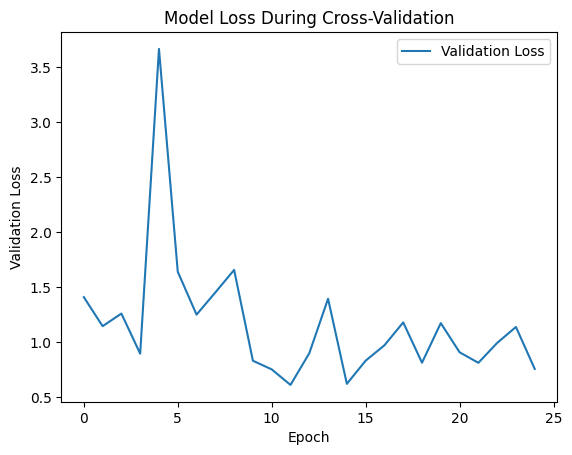

In [24]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

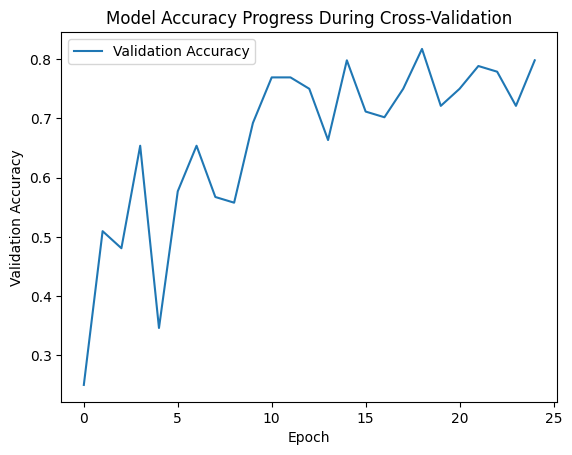

In [25]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [26]:
test_directory="/content/drive/MyDrive/Colab Notebooks/Proyectos_DS_2025/PDS_Operaciones/Test"

In [27]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6750 - loss: 1.4763 


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Accuracy Test : 0.675000011920929


In [28]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━

In [29]:
len(original)

40

In [30]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.625


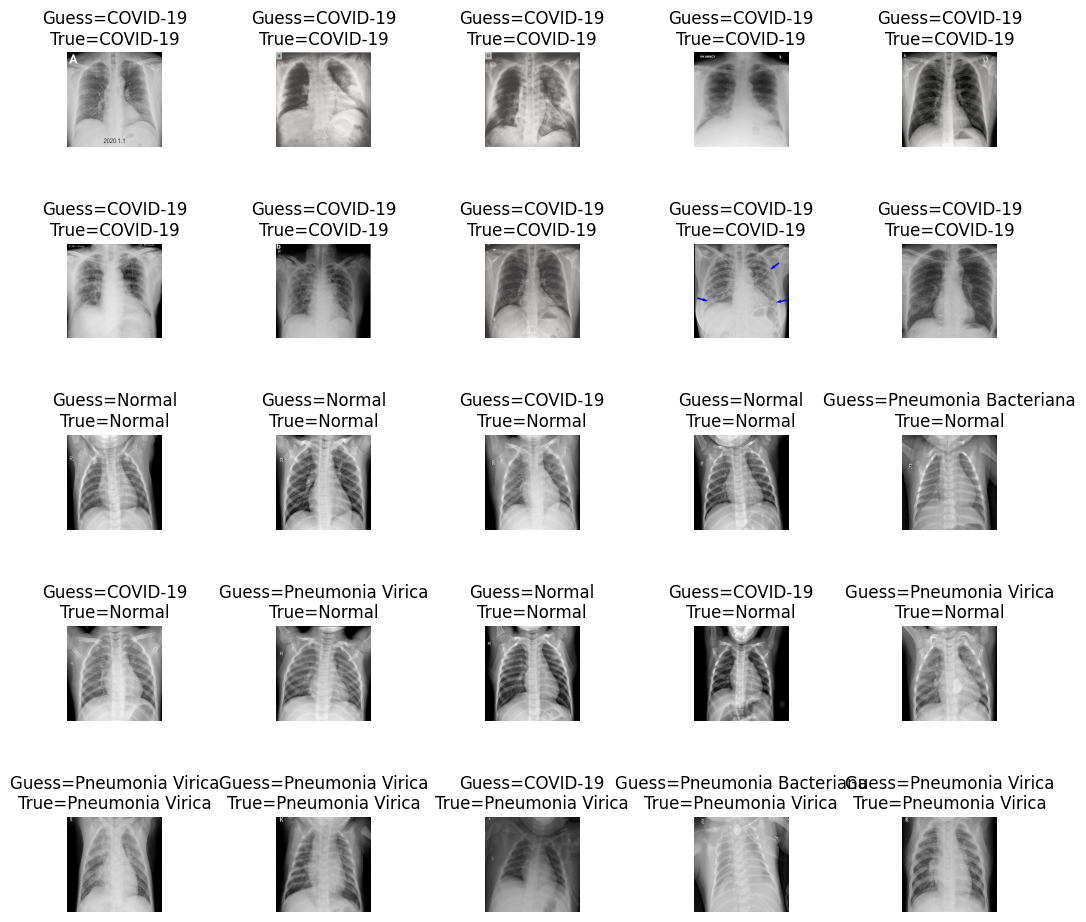

In [31]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2)

In [32]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.59      1.00      0.74        10
           1       0.67      0.40      0.50        10
           2       0.62      0.50      0.56        10
           3       0.67      0.60      0.63        10

    accuracy                           0.62        40
   macro avg       0.64      0.62      0.61        40
weighted avg       0.64      0.62      0.61        40



Text(0.5, 1.0, 'Confusion_matrix')

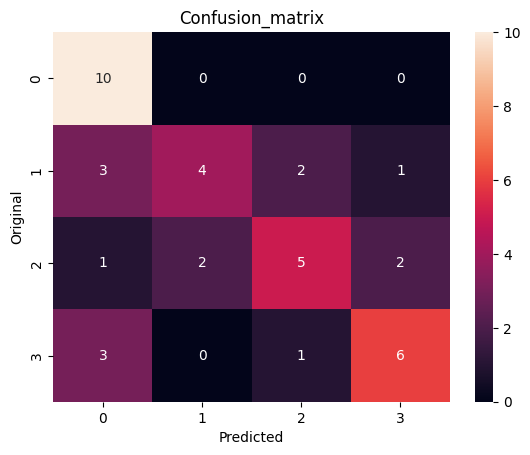

In [33]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

# Resumen del Proyecto y Conclusiones

Este proyecto tuvo como objetivo desarrollar un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para diagnosticar automáticamente diferentes condiciones pulmonares (COVID-19, Normal, Neumonía Virica, Neumonía Bacteriana) a partir de imágenes de radiografías de tórax.

Se utilizó un modelo pre-entrenado (ResNet50) como base, congelando la mayoría de sus capas y añadiendo capas densas personalizadas para la tarea de clasificación. El modelo fue entrenado con un conjunto de datos de radiografías de tórax, utilizando técnicas de aumento de datos para mejorar la generalización.

Los resultados de la evaluación en el conjunto de prueba mostraron una precisión general del 62.5%. Analizando el reporte de clasificación, se observa que el modelo predice mejor la condición de COVID-19 (clase 0) con un recall del 100%, aunque su precisión es del 59%. Para las clases Normal (clase 1), Neumonía Virica (clase 2) y Neumonía Bacteriana (clase 3), el rendimiento es más variable, con precisiones y recalls que oscilan entre 40% y 67%. Esto indica que el modelo tiene dificultades para distinguir consistentemente entre estas últimas categorías. La matriz de confusión detallada visualiza las predicciones correctas e incorrectas por clase.

**Conclusiones:**

El modelo desarrollado demuestra un potencial prometedor como herramienta de apoyo en el diagnóstico de condiciones pulmonares, especialmente para la detección de COVID-19. Sin embargo, la precisión general y el rendimiento variable en las otras clases sugieren que se necesita una mejora significativa antes de su aplicación clínica. Para optimizar el modelo, se recomiendan las siguientes acciones:

*   **Balanceo del conjunto de datos:** Si existe un desbalance entre las clases en el conjunto de entrenamiento, se deben aplicar técnicas como sobremuestreo (oversampling) de clases minoritarias o submuestreo (undersampling) de clases mayoritarias para mejorar el rendimiento en todas las categorías.
*   **Aumento de datos más avanzado:** Explorar técnicas de aumento de datos más sofisticadas como Mixup o Cutmix podría ayudar al modelo a generalizar mejor.
*   **Ajuste fino (Fine-tuning):** Descongelar y re-entrenar más capas del modelo base (ResNet50) con una tasa de aprendizaje baja podría permitir que el modelo aprenda características más específicas del conjunto de datos de radiografías de tórax.
*   **Optimización de hiperparámetros:** Realizar una búsqueda sistemática de los mejores hiperparámetros para el optimizador, la tasa de aprendizaje, la regularización (dropout, L2) y la arquitectura de las capas densas.
*   **Exploración de otras arquitecturas:** Evaluar el rendimiento de otras arquitecturas de CNN pre-entrenadas como VGG16, InceptionV3 o EfficientNet, que podrían ser más adecuadas para esta tarea.
*   **Análisis de errores:** Examinar las imágenes que el modelo clasifica incorrectamente para identificar patrones o características que confunden al modelo y ajustar el preprocesamiento o el modelo en consecuencia.
*   **Validación externa:** Evaluar el modelo en un conjunto de datos completamente independiente para asegurar su robustez y generalización a diferentes fuentes de datos.

Implementar estas recomendaciones podría conducir a un modelo más preciso y fiable para la clasificación de radiografías de tórax.